Library importing

In [1]:
import os
import pandas as pd
import regex as re
import numpy as np
import spacy
from rapidfuzz import process
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

Dataseti ayarlama ve yükleme

In [2]:
path = ".\datasets"

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\baros\AppData\Local\Temp\ipykernel_15640\2862975243.py:1: SyntaxWarning: invalid escape sequence '\d'
  path = ".\datasets"


In [3]:
def load_news_articles(base_path):
    data = []
    categories = os.listdir(base_path)
    
    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)
                with open(file_path, 'r', encoding = 'latin1') as file:
                    content = file.read()
                    data.append((content, category))
    
    return pd.DataFrame(data, columns = ['text', 'category'])

news_df = load_news_articles(path)

In [12]:
news_df.head()

,text,category
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [8]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      2225 non-null   object
 1   category  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [11]:
news_df["category"].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Named-Entitiy

In [13]:
def preserve_entities(text):
    doc = nlp(text)
    preserved = text
    for ent in doc.ents:
        tag = f"<{ent.label_}:{ent.text.replace(' ', '_')}>" # Replace spaces with underscores in the entity text
        preserved = preserved.replace(ent.text, tag) # Preserve the entity text
    return preserved

In [14]:
news_df['text_preserved'] = news_df['text'].apply(preserve_entities)

In [15]:
news_df.head()

,text,category,text_preserved
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,Ad sales boost <ORG:Time_Warner> profit\n\n<DA...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,Dollar gains on <PERSON:<PERSON:Greenspan>> sp...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,<ORG:<PERSON:<PERSON:<PERSON:<PERSON:<PERSON:Y...
3,High fuel prices hit BA's profits\n\nBritish A...,business,High fuel prices hit <ORG:<ORG:<ORG:<ORG:<ORG:...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,<PERSON:<ORG:<PERSON:<PERSON:<PERSON:<PERSON:<...


Regex

In [ ]:
def clean_text(text):
    
    text = re.sub(r'<.*?>', ' ', text)

    
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    
    text = re.sub(r'\S+@\S+', ' ', text)

    
    text = re.sub(r'\d+', ' ', text)

    
    text = re.sub(r'[^a-zA-Z\s<>_:]', ' ', text)  # <ENTITY_TAG>

    
    text = text.lower()

    
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [18]:
news_df['text_cleaned'] = news_df['text_preserved'].apply(clean_text)

In [19]:
print(news_df[['text', 'text_preserved', 'text_cleaned']].sample(1).to_string())

In [20]:
news_df.head()

,text,category,text_preserved,text_cleaned
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,Ad sales boost <ORG:Time_Warner> profit\n\n<DA...,ad sales boost profit profits at > media giant...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,Dollar gains on <PERSON:<PERSON:Greenspan>> sp...,dollar gains on > speech the dollar has hit it...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,<ORG:<PERSON:<PERSON:<PERSON:<PERSON:<PERSON:Y...,>>>>> unit buyer faces loan claim the owners o...
3,High fuel prices hit BA's profits\n\nBritish A...,business,High fuel prices hit <ORG:<ORG:<ORG:<ORG:<ORG:...,high fuel prices hit >>>>>>>>>> s profits has ...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,<PERSON:<ORG:<PERSON:<PERSON:<PERSON:<PERSON:<...,>>>>>>> takeover talk lifts domecq shares in d...


Normalizing

In [21]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  
    return text


Lemmatization

In [22]:
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])


Text Process

In [23]:
news_df['clean_text'] = news_df['text'].apply(preserve_entities)
news_df['clean_text'] = news_df['clean_text'].apply(normalize_text)
news_df['clean_text'] = news_df['clean_text'].apply(lemmatize_text)



Type Correction

In [27]:
def correct_typos(text, vocab, threshold=90):
    corrected_words = []
    for word in text.split():
        if word in vocab or word.startswith("<") or word.endswith(">"):
            corrected_words.append(word)
        else:
            match, score, _ = process.extractOne(word, vocab)
            if score >= threshold:
                corrected_words.append(match)
            else:
                corrected_words.append(word)
    return ' '.join(corrected_words)


Count Vectorizer

In [25]:
vectorizer_vocab = CountVectorizer(min_df=5)
vectorizer_vocab.fit(news_df['clean_text'])
vocab = set(vectorizer_vocab.get_feature_names_out())


In [28]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda text: correct_typos(text, vocab))

TF-IDF

In [29]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_df=0.80,
    min_df=3,
    max_features=8000,
    sublinear_tf=True,
    stop_words='english'
)
X_tfidf = vectorizer.fit_transform(news_df['clean_text'])


y = news_df['category']

In [30]:
print("TF-IDF shape:", X_tfidf.shape)
print("Sample feature names:", vectorizer.get_feature_names_out()[:10])


TF-IDF shape: (2225, 8000)
Sample feature names: ['10' '10 gamble' '100' '100 gamble' '10000' '100000' '10bn' '11'
 '11 gamble' '11bn']


Splitting and Naive Bayes Algorithm

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.2, random_state = 42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                precision    recall  f1-score   support

     business       0.93      0.96      0.94       115
entertainment       0.99      0.92      0.95        72
     politics       0.91      0.96      0.94        76
        sport       0.99      0.99      0.99       102
         tech       0.96      0.94      0.95        80

     accuracy                           0.96       445
    macro avg       0.96      0.95      0.95       445
 weighted avg       0.96      0.96      0.96       445



Confusion Matrix

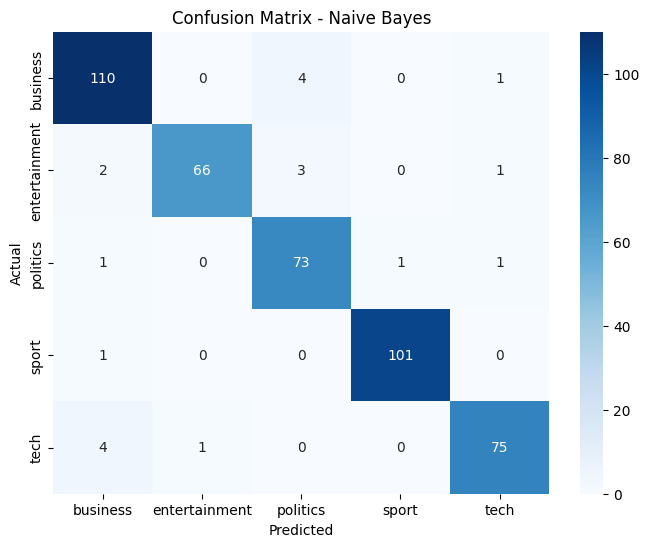

In [20]:
labels = sorted(news_df['category'].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

Top Features for Each Category

In [21]:
def show_top_features_nb(classifier, vectorizer, class_labels, n=10):
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_indices = np.argsort(classifier.feature_log_prob_[i])[-n:]
        top_features = [feature_names[j] for j in top_indices]
        print(f"\nTop features for '{class_label}':")
        print(", ".join(top_features))
show_top_features_nb(nb_model, vectorizer, nb_model.classes_)



Top features for 'business':
analyst, price, sale, economy, share, rise, growth, firm, market, company

Top features for 'entertainment':
work, singer, album, music, good, include, actor, award, star, film

Top features for 'politics':
secretary, leader, mr person, people, plan, party, minister, government, election, mr

Top features for 'sport':
disable, person person, coach, command, team, match, player, play, game, win

Top features for 'tech':
digital, mobile, service, net, software, use, computer, user, technology, people


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

Cross Validation

In [23]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Hyperparameter Tuning

In [ ]:
models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), [
        {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear']
        },
        {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['elasticnet'],
            'clf__solver': ['saga'],
            'clf__l1_ratio': [0.2, 0.5, 0.8]
        }
    ]),
    
    "DecisionTree": (DecisionTreeClassifier(random_state=42), {
        "clf__max_depth": [5, 10, 15, 20],
        "clf__min_samples_split": [5, 10, 20],
        "clf__min_samples_leaf": [2, 5, 10],
        "clf__max_features": ['sqrt', 'log2', None]
    }),
    
    "SVM": (LinearSVC(max_iter=10000, random_state=42), {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ['l1', 'l2'],
        "clf__dual": [False]
    }),
    
    "MLP": (MLPClassifier(max_iter=500, random_state=42), {
        "clf__hidden_layer_sizes": [(50,), (100,), (100, 50)],
        "clf__alpha": [0.001, 0.01, 0.1],
        "clf__validation_fraction": [0.1]
    })
}


Voting Ensemble (Logistic Regression + Support Vector Machine + Random Forest)

In [27]:
log_reg = LogisticRegression(C=1, penalty='l2', max_iter=1000)
svm = LinearSVC(C=0.1, max_iter=10000)
rf = RandomForestClassifier(n_estimators=100, max_depth=15, 
                            min_samples_split=10, random_state=42)

voting_ensemble = VotingClassifier(
    estimators=[('lr', log_reg), ('svm', svm), ('rf', rf)],
    voting='hard'
)

models["RandomForest"] = (RandomForestClassifier(random_state=42), {
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [10, 15, 20],
    "clf__min_samples_split": [5, 10],
    "clf__min_samples_leaf": [2, 5]
})

models["VotingEnsemble"] = (voting_ensemble, {})


Modeling with Hyperparameter Tuning

In [28]:
from sklearn.model_selection import cross_val_score

results = {}

for name, (model, param_grid) in models.items():
    print(f"\nTraining and tuning {name}...")
    pipeline = Pipeline([('clf', model)])
    
    grid = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=cv_strategy, 
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    cv_scores = cross_val_score(best_model, X_train, y_train, 
                                cv=cv_strategy, scoring='f1_macro')

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    print(f"{name}")
    print(f"  - CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
    print(f"  - Training Accuracy: {train_acc:.4f}")
    print(f"  - Testing Accuracy : {test_acc:.4f}")
    print(f"  - Gap: {train_acc - test_acc:.4f}")
    print(f"  - Best Params: {grid.best_params_}")

    results[name] = {
        'model': best_model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'cv_score': cv_mean,
        'cv_std': cv_std,
        'acc_gap': train_acc - test_acc,
        'params': grid.best_params_
    }



Training and tuning LogisticRegression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nlpproject\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Livan\OneDrive\Masaüstü\Work\NLP-Project\nl

LogisticRegression
  - CV Score: 0.9775 (+/- 0.0114)
  - Training Accuracy: 1.0000
  - Testing Accuracy : 0.9708
  - Gap: 0.0292
  - Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

Training and tuning DecisionTree...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
DecisionTree
  - CV Score: 0.8015 (+/- 0.0269)
  - Training Accuracy: 0.9348
  - Testing Accuracy : 0.8270
  - Gap: 0.1079
  - Best Params: {'clf__max_depth': 20, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 20}

Training and tuning SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
SVM
  - CV Score: 0.9812 (+/- 0.0125)
  - Training Accuracy: 1.0000
  - Testing Accuracy : 0.9730
  - Gap: 0.0270
  - Best Params: {'clf__C': 10, 'clf__dual': False, 'clf__penalty': 'l2'}

Training and tuning MLP...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

Model Accuracy Comparison

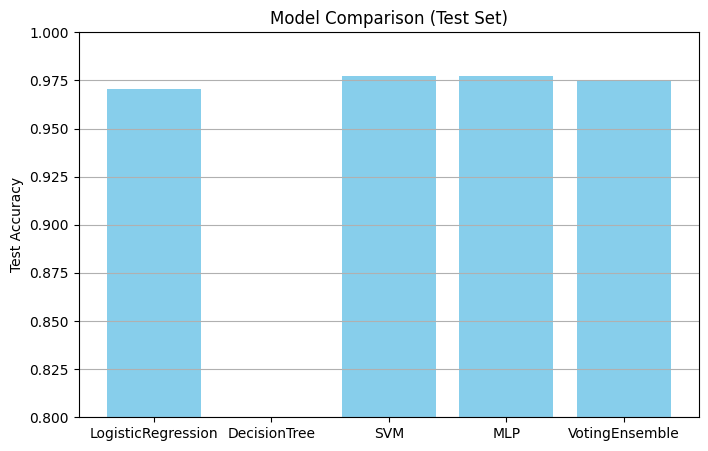

In [ ]:
names = list(results.keys())
accuracies = [results[name]['test_acc'] for name in names] 

plt.figure(figsize=(8, 5))
plt.bar(names, accuracies, color='skyblue')
plt.ylabel("Test Accuracy")
plt.title("Model Comparison (Test Set)")
plt.ylim(0.8, 1.0)
plt.grid(True, axis='y')
plt.show()


Model Training and Test Accuracy Comparison

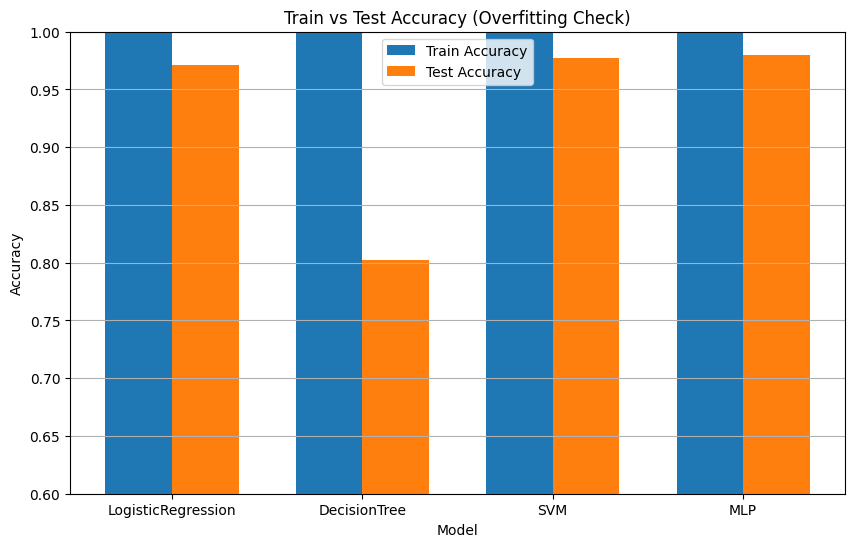

In [ ]:
model_names = list(results.keys())
train_scores = [results[m]['train_acc'] for m in model_names]
test_scores = [results[m]['test_acc'] for m in model_names]
gaps = [results[m]['acc_gap'] for m in model_names]

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(model_names))

plt.bar(x, train_scores, width=bar_width, label='Train Accuracy')
plt.bar([i + bar_width for i in x], test_scores, width=bar_width, label='Test Accuracy')
plt.xticks([i + bar_width / 2 for i in x], model_names)
plt.ylim(0.6, 1.0)
plt.title('Train vs Test Accuracy (Overfitting Check)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, axis='y')
plt.show()


Classification Report

In [ ]:
from sklearn.metrics import classification_report

print("\n" + "="*30)
print("Classification Reports")
print("="*30)

for name, data in results.items():
    model = data['model']
    y_pred = model.predict(X_test)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))



Classification Reports

Model: LogisticRegression
               precision    recall  f1-score   support

     business       0.94      0.97      0.96       115
entertainment       0.99      0.97      0.98        72
     politics       0.95      0.96      0.95        76
        sport       1.00      0.99      1.00       102
         tech       0.99      0.95      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445


Model: DecisionTree
               precision    recall  f1-score   support

     business       0.78      0.76      0.77       115
entertainment       0.83      0.68      0.75        72
     politics       0.74      0.82      0.78        76
        sport       0.82      0.84      0.83       102
         tech       0.78      0.84      0.81        80

     accuracy                           0.79       445
    macro avg       0.79      0.79      0.7

Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_macro'
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
    plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curves - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

best_model_name = max(results.keys(), key=lambda k: results[k]['test_acc'])
best_model = results[best_model_name]['model']
plot_learning_curves(best_model, X_train, y_train, best_model_name)

print(f"\nBest model: {best_model_name} with test accuracy: {results[best_model_name]['test_acc']:.4f}")


In [ ]:
import joblib

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(results["VotingEnsemble"]["model"], "news_classifier.pkl")


['news_classifier.pkl']